In [5]:
#TFIDF Py

import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_pickle_file(filepath):
    """
    load pickle file from filepath
    """
    tmp = open(filepath, "rb")
    return pickle.load(tmp)

def save_pickle_file(data, filepath="tfidf1.pickle"):
    """
    save data to pickle file
    """
    pickle.dump(data, open(filepath, "wb+"))

def get_article_body(data_dict,section='body'):
    """
    input is dictionary where the keys are PMIDs and the values are the paper attributes
    return dictionary where the keys are PMIDS and the values are the paper bodies
    """
    new_dict = {}
    for k,v in data_dict.items():
        new_dict[k] = v[section]
    return new_dict


def get_tfidf(corpus):
    """
    input is arr with columns = ['pmid', 'body']
    return tfidf
    """
    vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=500,
                                max_df=0.02,min_df=.0005)
    X = vectorizer.fit_transform(corpus)
    # vocab = vectorizer.vocabulary_
    feature_name = vectorizer.get_feature_names()
    return X, feature_name

def assemble_results(pmids, tfidf):
    """
    inputs are 1 dimensional arrays with n rows
    output is array with both inputs as columns
    """
    return np.concatenate((np.expand_dims(list(pmids), axis=1), np.expand_dims(list(tfidf), axis=1)), axis=1)

if __name__ == "__main__":
    """
    take in sample_v2.pickle and return pickle file with ["pmid","tfidf"]
    """

    data_dict = get_pickle_file("Downloads/category.pickle")
    paper_body_dict = get_article_body(data_dict)
    print("bodies collected...")

    # i = 0
    # new_dict = {}
    # for k,v in paper_body_dict.items():
    #     if i < 50:
    #         new_dict[k] = v
    #         i += 1
    #     else:
    #         break

    pmids = paper_body_dict.keys()
    corpus = paper_body_dict.values()
    print("transformed to array...")

    X, feature_name = get_tfidf(corpus)
    print("tfidf calculated...")

    pmid_tfidf_array = assemble_results(pmids, X)
    save_pickle_file(pmid_tfidf_array)
    print("done")

bodies collected...
transformed to array...
tfidf calculated...
done


In [6]:
# KMeans Py

from sklearn.cluster import KMeans

def get_pickle_file(filepath):
    """
    load pickle file from filepath
    """
    tmp = open(filepath, "rb")
    return pickle.load(tmp)

def save_pickle_file(data, filepath):
    """
    save data to pickle file
    """
    pickle.dump(data, open(filepath, "wb+"))

def get_tfidf(data):
    """
    input is numpy array with columns = [pmids, tfidf sparce matrices]
    output is dense array with n_samples x n_features
    """
    X = np.zeros((len(data), data[0,1].shape[1]))
    for i,row in enumerate(data[:,1]):
        X[i] = row.todense()[0]
    return X

def assemble_results(input, predictions):
    """
    inputs are 1 dimensional arrays with n rows
    output is array with both inputs as columns
    """
    return np.concatenate((input, np.expand_dims(predictions, axis=1)), axis=1)

if __name__ == "__main__":
    data = get_pickle_file("tfidf1.pickle")
    X = get_tfidf(data)

    cluster_ranges = [2,5,10]
    for c in cluster_ranges:
        print("Kmeans for {} clusters...".format(c))
        kmeans = KMeans(n_clusters=c, random_state=0).fit(X)
        print("model fit...")
        predictions = kmeans.labels_
        results = assemble_results(data, predictions)
        print("results assembled...")
        save_pickle_file(results, "kmeans_{}1.pickle".format(c))

Kmeans for 2 clusters...
model fit...
results assembled...
Kmeans for 5 clusters...
model fit...
results assembled...
Kmeans for 10 clusters...
model fit...
results assembled...


In [13]:
# Tables

# from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import numpy as np
import pandas as pd

res_df = pd.DataFrame(results,columns = ['PMID','Matrix','Cluster'])

titles = get_article_body(data_dict,section='Article Title')
title_df = pd.DataFrame.from_dict(titles,orient='index')
title_df.reset_index()
title_df2 = title_df.rename(columns={'index':'PMID',0:'Article Title'})

Journal = get_article_body(data_dict,section='Journal Title')
Journal_df = pd.DataFrame.from_dict(Journal,orient='index')
Journal_df.reset_index()
Journal_df2 = Journal_df.rename(columns={'index':'PMID',0:'Journal Title'})

summary_df = res_df.join(title_df2,on='PMID',lsuffix='L')
summary_df2 = summary_df.join(Journal_df2,on='PMID',lsuffix='L')

C:\Users\dan.meurer\AppData\Local\Continuum\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\dan.meurer\AppData\Local\Continuum\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


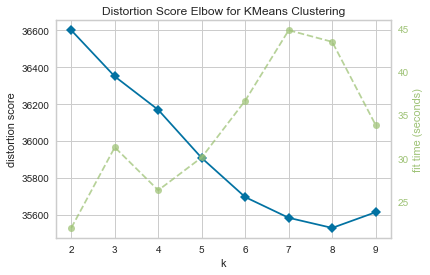

In [9]:
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\dan.meurer\AppData\Local\Continuum\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\dan.meurer\AppData\Local\Continuum\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


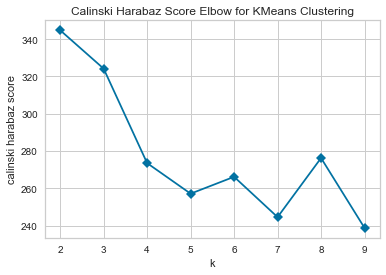

In [10]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [17]:
# Top Words per cluster and some titles

print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 

for i in range(10):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :30]: #replace 30 with n words per cluster
        print(' %s' % [feature_name[ind].split(' ')][0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    print()
    
    for title in summary_df2[summary_df2['Cluster']==i]['Article Title'].head():
        print(' - %s' % title)
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d Journal:" % i, end='')
    print()
    
    for title in set(summary_df2[summary_df2['Cluster']==i]['Journal Title']):
        print(' - %s' % title)
    print() #add whitespace
    print() #add whitespace
    
    
#     print("Cluster %d Type:" % i, end='')
#     print()
    
#     for title in summary_df[summary_df['Cluster']==i]['Type'].head():
#         print(' - %s' % title)
#     print() #add whitespace
#     print() #add whitespace
    
#     print("Year %d Year:" % i, end='')
#     print()
    
#     for title in summary_df[summary_df['Cluster']==i]['Year'].head():
#         print(' - %s' % title)
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: immunodeficiency, antiretroviral, hiv, sexual, hepatitis, viral, infected, cd4, adherence, africa, count, clinic, workers, partner, pregnant, initiation, antenatal, ethiopia, tuberculosis, alcohol, persons, behaviors, deficiency, infants, adolescents, late, past, uptake, facilities, surveillance,

Cluster 0 titles:
 - prevalence and correlates of anemia among human immunodeficiency virus infected patients on highly active antiretroviral therapy at zewditu memorial hospital ethiopia
 - prevalence and associated risk factors of anemia among human immunodeficiency virus infected children attending gondar university hospital northwest ethiopia a cross sectional study
 - prevalence of transfusion transmissible infections in blood donors of pakistan
 - profile of blood cell abnormalities among antiretroviral therapy naïve human immunodeficiency virus patients attending the yaounde university teaching hospital cameroon
 - prevalence of anemia before an

In [ ]:
# order_centroids

For n_clusters = 2 The average silhouette_score is : 0.009057795722162384
For n_clusters = 5 The average silhouette_score is : 0.013448412761395068
For n_clusters = 10 The average silhouette_score is : 0.01808565491395961


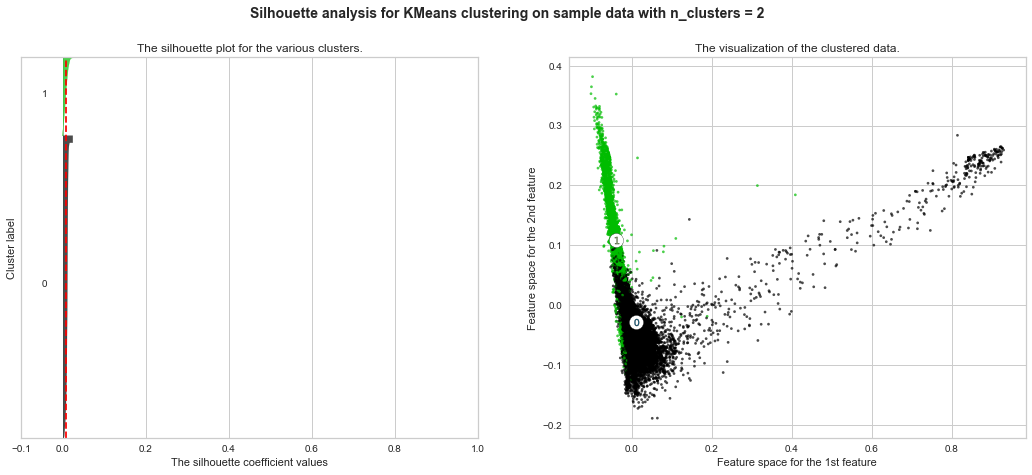

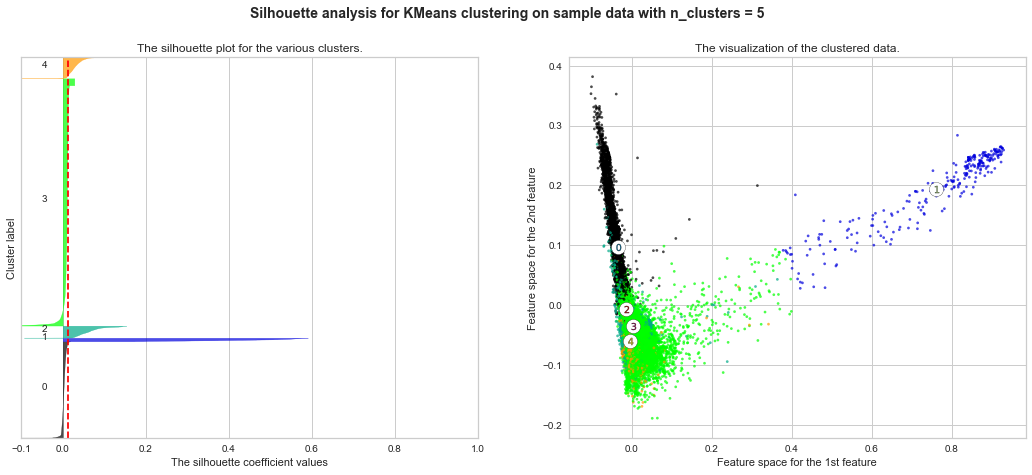

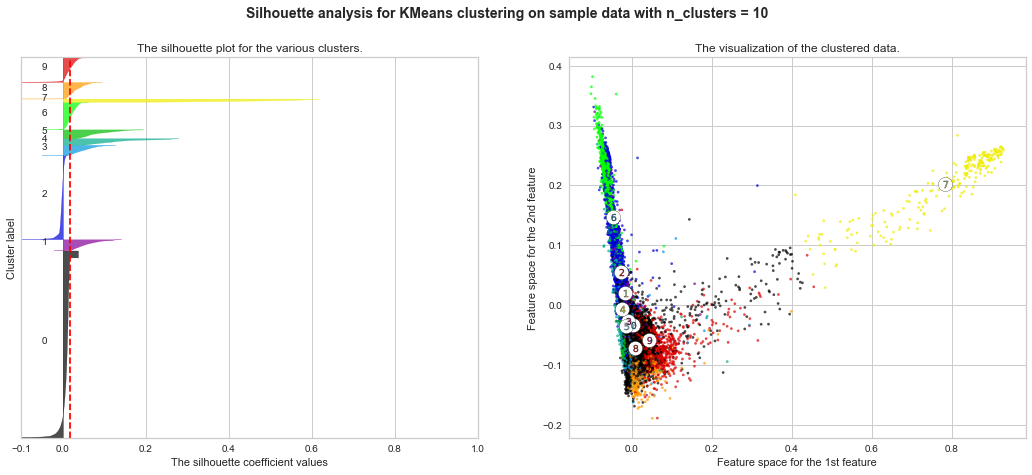

In [9]:
# Cluster Graphs

range_n_clusters = [2, 5, 10]

data = get_pickle_file("tfidf1.pickle")
X = get_tfidf(data)
pca_num_components = 2

P_model = PCA(n_components=pca_num_components).fit(X)
Px = P_model.transform(X)

for n_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)   
    cluster_labels = kmeans.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Px[:, 0], Px[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = P_model.transform(kmeans.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
# len(kmeans.cluster_centers_)

In [ ]:
# len(Px)

For n_clusters = 2 The average silhouette_score is : 0.009057795722162384


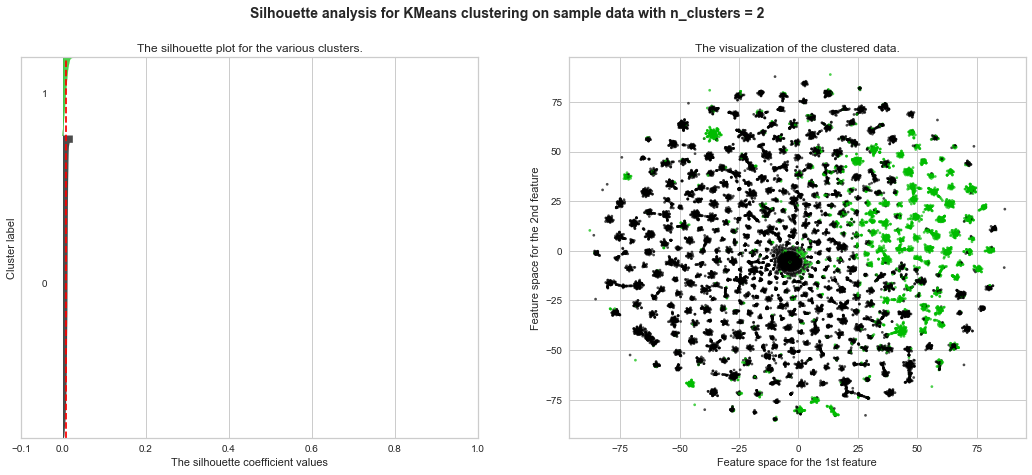

In [10]:
# Cluster Graphs (replacing PCA with t-snt)
from sklearn.manifold import TSNE

range_n_clusters = [2]

data = get_pickle_file("tfidf1.pickle")
X = get_tfidf(data)
tsne_num_components = 2

P_model = TSNE(n_components=tsne_num_components).fit(X)
# Px = P_model.transform(X)
tsne_obj= P_model.fit_transform(X)

for n_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)   
    cluster_labels = kmeans.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsne_obj[:, 0], tsne_obj[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = P_model.fit_transform(kmeans.cluster_centers_)
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 10 The average silhouette_score is : 0.01808565491395961


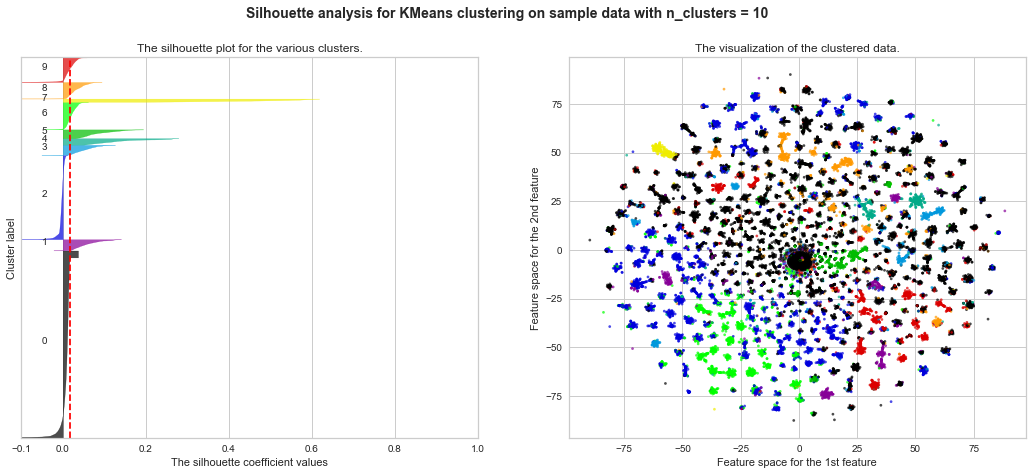

In [11]:
# Cluster Graphs (replacing PCA with t-snt)
from sklearn.manifold import TSNE

range_n_clusters = [10]

data = get_pickle_file("tfidf1.pickle")
X = get_tfidf(data)
tsne_num_components = 2

P_model = TSNE(n_components=tsne_num_components).fit(X)
# Px = P_model.transform(X)
tsne_obj= P_model.fit_transform(X)

for n_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)   
    cluster_labels = kmeans.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsne_obj[:, 0], tsne_obj[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = P_model.fit_transform(kmeans.cluster_centers_)
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
# # Cluster Graphs (replacing PCA with t-snt)
# from sklearn.manifold import TSNE

# range_n_clusters = [27]

# data = get_pickle_file("tfidf1.pickle")
# X = get_tfidf(data)
# tsne_num_components = 2

# P_model = TSNE(n_components=tsne_num_components).fit(X)
# # Px = P_model.transform(X)
# tsne_obj= P_model.fit_transform(X)

# for n_clusters in range_n_clusters:

#     kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)   
#     cluster_labels = kmeans.labels_
    
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / 27)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / 27)
#     ax2.scatter(tsne_obj[:, 0], tsne_obj[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

# #     # Labeling the clusters
# #     centers = P_model.fit_transform(kmeans.cluster_centers_)
# #     # Draw white circles at cluster centers
# #     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
# #                 c="white", alpha=1, s=200, edgecolor='k')

# #     for i, c in enumerate(centers):
# #         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
# #                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')